In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Load the dataset
data = pd.read_csv("data_after_EDA.csv")
nlp_data = pd.read_csv('updated_dataset.csv', usecols=['Main Diagnosis'] + ['word_' + str(i) for i in range(100)])

# Drop the 'Main Diagnosis' column
data.drop(columns=['Hospital','Deparment','Main Diagnosis','Discharge Time'], inplace=True)

# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])
data['Hour'] = data['Arrival Time'].dt.hour
data['DayOfYear'] = data['Arrival Time'].dt.dayofyear

# Convert the 'Severity Level' column to numerical
level_mapping = {
    'Level Ⅰ': 1,
    'Level Ⅱ': 2,
    'Level Ⅲ': 3,
    'Level Ⅳ': 4,
    'Level Ⅴ': 5,
    'Unrated': 0
}

data['Severity Level'] = data['Severity Level'].replace(level_mapping)
data['Severity Level'] = data['Severity Level'].astype(int)

/var/folders/s9/js1_pzls6t9cp_gclfqd6yn80000gn/T/ipykernel_76770/3606160821.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Severity Level'] = data['Severity Level'].replace(level_mapping)


  ROWNUM Eligibility Class  Gender        Arrival Time  Severity Level  \
0      1  ROYAL COMMISSION  Female 2023-12-13 13:17:48               4   
1      2  ROYAL COMMISSION  Female 2023-12-08 10:59:28               3   
2      3  ROYAL COMMISSION  Female 2023-11-05 14:03:02               3   
3      4  ROYAL COMMISSION  Female 2023-10-07 22:57:41               3   
4      5  ROYAL COMMISSION  Female 2023-10-21 21:32:17               4   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    191.0   
1                     7.0                     111.0                    104.0   
2                    24.0                      51.0                     27.0   
3                    26.0                      71.0                      0.0   
4                    56.0                      98.0                     42.0   

   Cluster  No Treatment  Hour  DayOfYear  Emergency  
0        2         

/var/folders/s9/js1_pzls6t9cp_gclfqd6yn80000gn/T/ipykernel_76770/3361529752.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=CTAS_counts.index, y=CTAS_counts.values, palette='viridis')


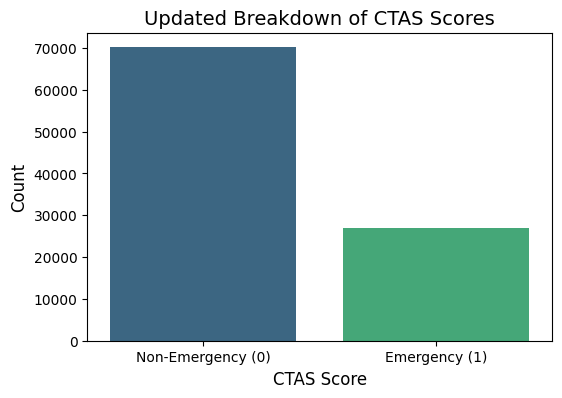

In [3]:
# Grouping the KTAS classes into emergency (1) and non-emergency (0)
data["Emergency"] = np.where(data["Severity Level"] < 4, 1, 0)
print(data.head())

# Count the values in Emergency
CTAS_counts = data['Emergency'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=CTAS_counts.index, y=CTAS_counts.values, palette='viridis')

# Set the labels and title
plt.xlabel('CTAS Score', size=12)
plt.ylabel('Count', size=12)
plt.title('Updated Breakdown of CTAS Scores', size=14)

# Show the plot
plt.xticks(ticks=[0, 1], labels=['Non-Emergency (0)', 'Emergency (1)'])  # Customize x-ticks if necessary
plt.show()

In [4]:
# Combine the data with the NLP data
combined_data = data.join(nlp_data, how='left')
print(combined_data.head())

  ROWNUM Eligibility Class  Gender        Arrival Time  Severity Level  \
0      1  ROYAL COMMISSION  Female 2023-12-13 13:17:48               4   
1      2  ROYAL COMMISSION  Female 2023-12-08 10:59:28               3   
2      3  ROYAL COMMISSION  Female 2023-11-05 14:03:02               3   
3      4  ROYAL COMMISSION  Female 2023-10-07 22:57:41               3   
4      5  ROYAL COMMISSION  Female 2023-10-21 21:32:17               4   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    191.0   
1                     7.0                     111.0                    104.0   
2                    24.0                      51.0                     27.0   
3                    26.0                      71.0                      0.0   
4                    56.0                      98.0                     42.0   

   Cluster  No Treatment  ...  word_90  word_91  word_92 word_93  word_94 

In [8]:
from sklearn.preprocessing import LabelEncoder
data['Waiting Time (Minutes)'] = data['Waiting Time (Minutes)'].astype(int)
data['Length of Stay (Minutes)'] = data['Length of Stay (Minutes)'].astype(int)
data['Treatment Time(Minutes)'] = data['Treatment Time(Minutes)'].astype(int)

label_encoders = {}
for column in ['Eligibility Class', 'Gender']:
    le = LabelEncoder()
    combined_data[column] = le.fit_transform(combined_data[column])
    label_encoders[column] = le

# Use the first 80% of the dataset
train_size = int(0.8 * len(combined_data))
train_data = combined_data[:train_size]

# Now, select features and target from the first 80%
features = train_data[['Eligibility Class', 'Gender', 'Waiting Time (Minutes)', 'Length of Stay (Minutes)', 'Treatment Time(Minutes)', 'Cluster', 'No Treatment'] + [f'word_{i}' for i in range(100)]]
target = train_data['Severity Level']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


print(X_train.dtypes)

Eligibility Class             int64
Gender                        int64
Waiting Time (Minutes)      float64
Length of Stay (Minutes)    float64
Treatment Time(Minutes)     float64
                             ...   
word_95                       int64
word_96                       int64
word_97                       int64
word_98                       int64
word_99                       int64
Length: 107, dtype: object


In [9]:
# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train
results = {}
for name, clf in classifiers.items():
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    results[name] = {'accuracy': accuracy, 'report': report, 'confusion_matrix': confusion}

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metr

Model: Logistic Regression
Accuracy: 0.7623854155937789
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.25      0.33       416
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        75
           3       0.75      0.50      0.60      4885
           4       0.77      0.94      0.85     13045
           5       0.00      0.00      0.00       994

    accuracy                           0.76     19418
   macro avg       0.33      0.28      0.30     19418
weighted avg       0.72      0.76      0.73     19418



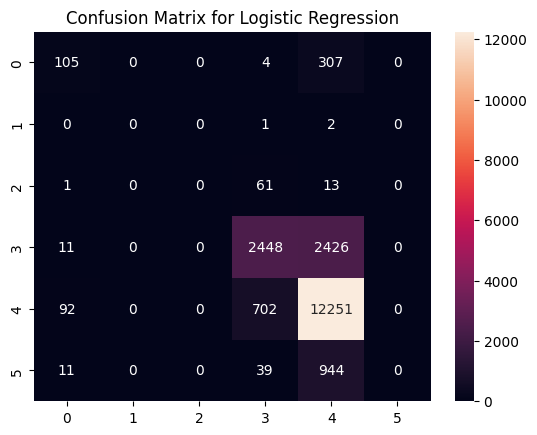

Model: Random Forest
Accuracy: 0.7548666186012978
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.61       416
           1       0.00      0.00      0.00         3
           2       0.08      0.01      0.02        75
           3       0.67      0.55      0.61      4885
           4       0.80      0.88      0.84     13045
           5       0.40      0.19      0.26       994

    accuracy                           0.75     19418
   macro avg       0.43      0.37      0.39     19418
weighted avg       0.74      0.75      0.74     19418



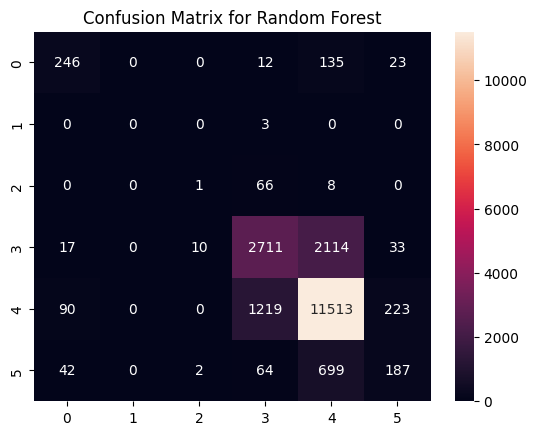

Model: SVM
Accuracy: 0.760016479555052
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       416
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        75
           3       0.74      0.51      0.60      4885
           4       0.76      0.94      0.84     13045
           5       0.00      0.00      0.00       994

    accuracy                           0.76     19418
   macro avg       0.25      0.24      0.24     19418
weighted avg       0.70      0.76      0.72     19418



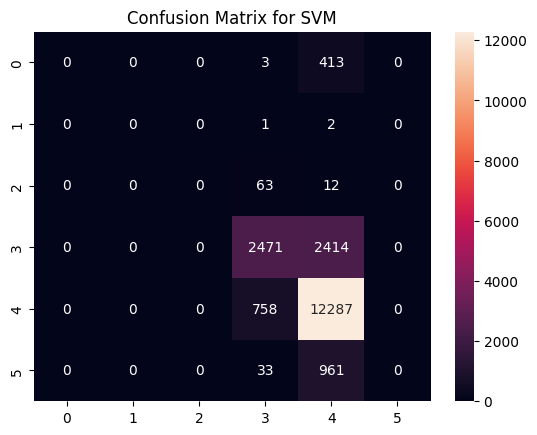

Model: KNN
Accuracy: 0.738284066330209
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.69      0.60       416
           1       0.00      0.00      0.00         3
           2       0.05      0.01      0.02        75
           3       0.62      0.55      0.59      4885
           4       0.79      0.87      0.82     13045
           5       0.29      0.04      0.07       994

    accuracy                           0.74     19418
   macro avg       0.38      0.36      0.35     19418
weighted avg       0.71      0.74      0.72     19418



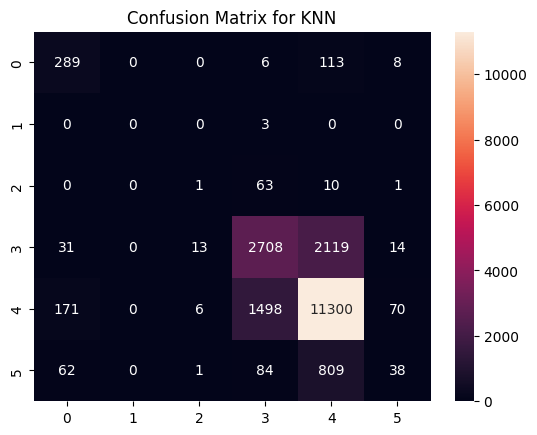

Model: Naive Bayes
Accuracy: 0.1583067257184056
Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.88      0.10       416
           1       0.00      1.00      0.00         3
           2       0.01      0.29      0.01        75
           3       0.64      0.09      0.16      4885
           4       0.81      0.16      0.27     13045
           5       0.06      0.10      0.08       994

    accuracy                           0.16     19418
   macro avg       0.26      0.42      0.10     19418
weighted avg       0.71      0.16      0.23     19418



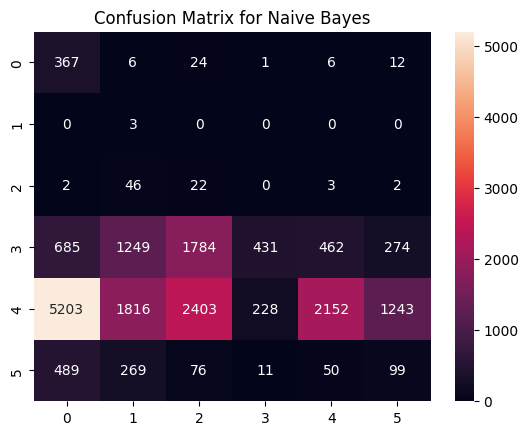

In [7]:
# Evaluate each classifier
for name, result in results.items():
    print(f"Model: {name}")
    print("Accuracy:", result['accuracy'])
    print("Classification Report:")
    print(result['report'])
    sns.heatmap(result['confusion_matrix'], annot=True, fmt="d")
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=200)

# Initialize RFE with the Logistic Regression model and specify the number of features you want to select
rfe = RFE(estimator=model, n_features_to_select=10)  # Change '10' to the number of features you want

# Fit RFE on training data
rfe.fit(X_train, y_train)

# Get the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Train the Logistic Regression model on selected features
model.fit(X_train_rfe, y_train)

# Make predictions and evaluate
y_pred_rfe = model.predict(X_test_rfe)
print("Accuracy with RFE:", accuracy_score(y_test, y_pred_rfe))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Accuracy with RFE: 0.7755391052462182


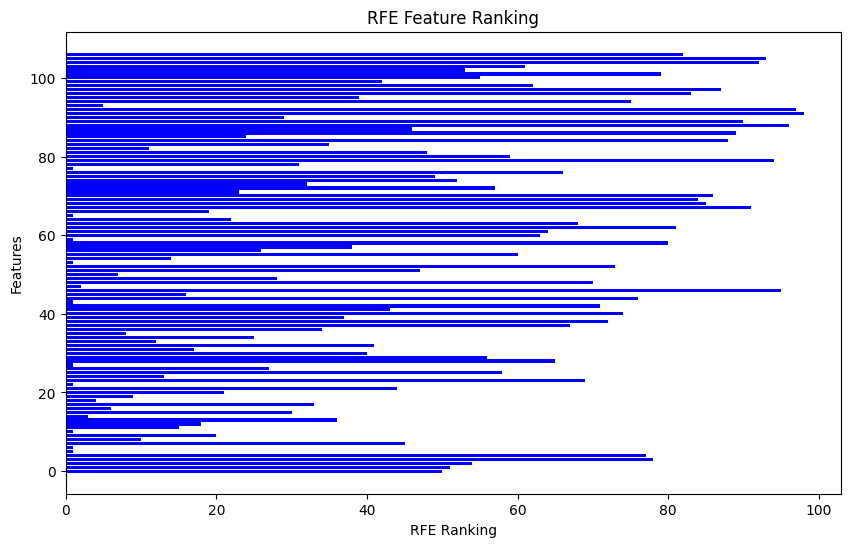

In [11]:
# Get RFE ranking of features
rfe_ranking = rfe.ranking_

# Plot feature ranking (smaller is better, 1 means selected)
plt.figure(figsize=(10, 6))
plt.barh(range(len(rfe_ranking)), rfe_ranking, color='blue')
plt.xlabel('RFE Ranking')
plt.ylabel('Features')
plt.title('RFE Feature Ranking')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Accuracy: 0.7755391052462182
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62       319
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        61
           3       0.75      0.47      0.58      3742
           4       0.78      0.94      0.86     10596
           5       0.68      0.18      0.29       816

    accuracy                           0.78     15535
   macro avg       0.47      0.37      0.39     15535
weighted avg       0.77      0.78      0.75     15535



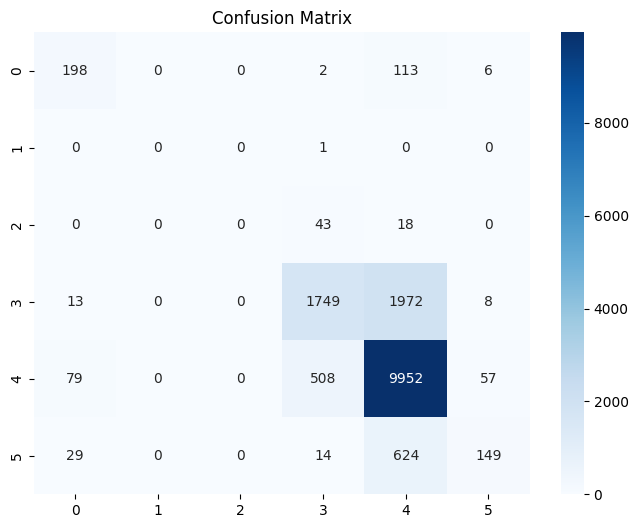

In [12]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_rfe)
report = classification_report(y_test, y_pred_rfe)
confusion = confusion_matrix(y_test, y_pred_rfe)

# Print results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Validation Accuracy: 0.7319497373570913
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.68      0.64       369
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00       128
           3       0.75      0.38      0.50      5580
           4       0.73      0.94      0.82     12455
           5       0.62      0.18      0.28       875

    accuracy                           0.73     19418
   macro avg       0.45      0.36      0.37     19418
weighted avg       0.73      0.73      0.70     19418



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

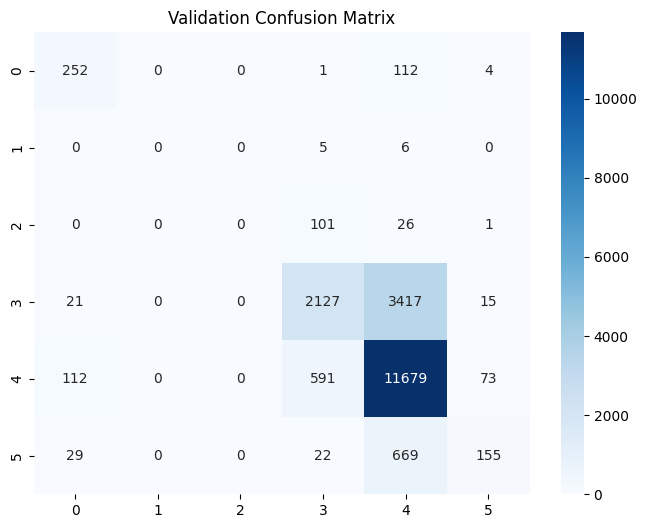

In [17]:
# Apply the same RFE transformation on the validation set
X_val_rfe = rfe.transform(X_val)  # Transform validation features using RFE

# Predict on validation data using the trained model
y_val_pred = model.predict(X_val_rfe)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Generate confusion matrix and classification report for validation set
val_confusion = confusion_matrix(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

# Print classification report
print("Validation Classification Report:\n", val_report)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.show()


In [20]:
''' this result is reasonable but can likely be improved by fine-tuning the model or addressing class imbalance for certain severity levels.'''

# Train the model on the training set
model.fit(X_train_rfe, y_train)

# Calculate accuracy on the training set
training_accuracy = model.score(X_train_rfe, y_train)

# Calculate accuracy on the validation set
validation_accuracy = accuracy_score(y_val, model.predict(X_val_rfe))

# Print the accuracies
print(f"Training Accuracy: {training_accuracy}")
print(f"Validation Accuracy: {validation_accuracy}")


Training Accuracy: 0.7788596166535237
Validation Accuracy: 0.7319497373570913


In [22]:
#print those extreme wrong-classfied values

# 找到被错误分类为 0 的样本，真实标签是 4 或 5
wrongly_classified_as_0 = validation_data[(y_val_pred == 0) & ((y_val == 4) | (y_val == 5))]
print("True 4/5, classified as 0：")
print(wrongly_classified_as_0)

# 找到被错误分类为 4 或 5 的样本，真实标签是 0
wrongly_classified_as_4_or_5 = validation_data[(y_val_pred == 4) | (y_val_pred == 5) & (y_val == 0)]
print("True 0, classified as 4/5：")
print(wrongly_classified_as_4_or_5)


True 4/5, classified as 0：
       ROWNUM  Eligibility Class  Gender        Arrival Time  Severity Level  \
77808  77,815                  2       1 2023-10-22 22:00:04               4   
77858  77,865                  1       1 2023-06-10 07:17:05               5   
77859  77,866                  1       1 2023-06-01 06:15:23               4   
78104  78,111                  1       1 2023-09-04 20:18:54               4   
78169  78,176                  1       1 2023-02-07 21:53:16               4   
...       ...                ...     ...                 ...             ...   
96635  96,642                  2       1 2023-11-28 13:57:04               4   
96642  96,649                  1       0 2023-05-12 14:35:00               5   
96648  96,655                  3       0 2023-10-10 20:39:37               4   
96768  96,775                  1       1 2023-10-14 16:17:06               4   
97006  97,013                  2       1 2023-06-02 21:47:18               4   

       Waiti

In [ ]:
# The reason of that is the imbalance of the dataset, we can use SMOTE to balance the dataset


Accuracy: 0.7148007003810897


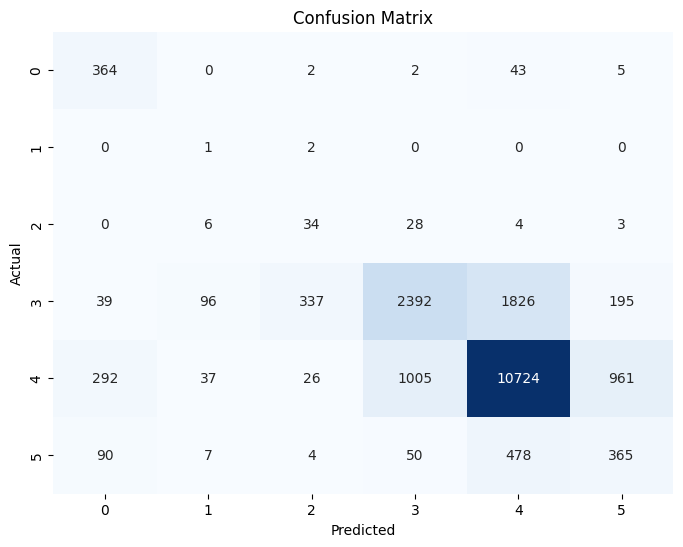

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.88      0.61       416
           1       0.01      0.33      0.01         3
           2       0.08      0.45      0.14        75
           3       0.69      0.49      0.57      4885
           4       0.82      0.82      0.82     13045
           5       0.24      0.37      0.29       994

    accuracy                           0.71     19418
   macro avg       0.38      0.56      0.41     19418
weighted avg       0.75      0.71      0.72     19418



In [38]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and target
X = combined_data[['Eligibility Class', 'Gender', 'Waiting Time (Minutes)', 'Length of Stay (Minutes)', 'Treatment Time(Minutes)', 'Cluster', 'No Treatment'] + [f'word_{i}' for i in range(100)]]
y = combined_data['Severity Level']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)

# Train Logistic Regression with increased max_iter
model = LogisticRegression(max_iter=500)
model.fit(X_train_sm, y_train_sm)

# Evaluate on test data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Output accuracy
print(f'Accuracy: {accuracy}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)
